# Bike Share Rebalancing With Mathematical Optimization

Bike share systems have become an effective commuting method globally for everyday urban dwellers as well as tourists.

Citi-Bike in NYC being the largest Bike-Sharing network had 1,588 active stations and 25,575 active bikes in July 2022.

Over 3 million rides were completed July 2022 that cover NYC/Hoboken/Jersey City, with around 150,000 active annual members.

During rush hours there are many bike stations that have a high demand for bikes, which means their out-flow of bikes is greater than their in-flow in these stations. 

Meanwhile there are stations that have a high demand for docks (riders return their bikes to these stations) which means their in-flow of bikes is greater than their out-flow.

Lack of available bikes or docks in high-demand stations can cause major imbalance in the bike sharing network and result in customer dissatisfaction and lost revenue.

To tackle this problem, bikes are relocated between stations to create a balance between supply and demand.

## Problem Statement and Solution Approach

Using historical Citi-bike data in NYC and Jersey area during July 2022, we like to know:
- What is the demand for bikes per hour at each station during the first week of August?
- Knowing the demand, how can we minimize loss of sale?

Loss of sale is caused by lack of bikes when customers demand them. So, bikes should be transfered from stations with higher in-flow of bikes to those with higher out-flow of bikes. 

So, first, number of bikes to be added to or removed from each station during each hour should be determined. Then, the physical transfer of bikes between stations should be scheduled. 

In this notebook, we'll focus on the first part and at the end, discuss how the second part can be solved.
We'll use a mixture of Machine Learning (ML) and Mathematical Optimization (MO) to solve this problem. 

**Solution Approach**
The solution approach is comprised of two steps:
- **Step 1**: We use the historical Citi-bike data in NYC and Jersey area during July 2022 and use an ML model to predict the number of in-flow and out-flow of bikes per hour at each station for the first week of August. This notebook accomplishes this step.
- **Step 2**: We use an MO model to decide how many bikes should be added to or removed from each station during each hour so that the total loss of sale is minimized. This is done in [bike_rebalancing](bike_rebalancing.ipynb) Notebook.

To ensure that everyone can run the notebook with the gurobi restricted license, we reduce the size of the data. To achieve that, we focus on the top 50 stations during the morning rush hours (7 am to 9 am).

The top stations are chosen using the PageRank algorithm.

# Import Packages

In [1]:
import datetime
import io
import json
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from zipfile import ZipFile

# Collect, Analyze, and Create Required Data

## Citi Bike Trip Histories

To get Citi Bike trip data:
- Go to [this](https://ride.citibikenyc.com/system-data) link
- Click the link under Citi Bike Trip Histories
- Download "[202207-citbike-tripdata.csv.zip](https://s3.amazonaws.com/tripdata/202207-citbike-tripdata.csv.zip)" and "[JC-202207-citbike-tripdata.csv.zip](https://s3.amazonaws.com/tripdata/JC-202207-citbike-tripdata.csv.zip)"


[July Citi-Bike Monthly Report](https://mot-marketing-whitelabel-prod.s3.amazonaws.com/nyc/July-2022-Citi-Bike-Monthly-Report.pdf) Stats:

- Average Bike Fleet: 25,575 Bikes
- Active Stations: 1,588
- Average Rides/Day: 109,305 - each bike used 4.13 times/day


In [2]:
def download_zip_to_dataframe(url):
    response = requests.get(url)
    with ZipFile(io.BytesIO(response.content)) as zf:
        with zf.open(zf.namelist()[0]) as f:
            df = pd.read_csv(f, low_memory=False)
    return df

In [3]:
# Read the data directly from the url
# NYC data
nyc_citi_jul_2022 = download_zip_to_dataframe('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/optimization101/bike_share/202207-citbike-tripdata.csv.zip')
# Jersey data
jersey_citi_jul_2022 = download_zip_to_dataframe('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/optimization101/bike_share/JC-202207-citbike-tripdata.csv.zip')
citi_jul_network = pd.concat([nyc_citi_jul_2022, jersey_citi_jul_2022])
pd.isnull(citi_jul_network).sum()  # count of null values in each column

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
start_station_id         0
end_station_name      9756
end_station_id        9756
start_lat                0
start_lng                0
end_lat               4857
end_lng               4857
member_casual            0
dtype: int64

In [4]:
# There is a small number of missing end stations. drop them
citi_jul_network.dropna(inplace=True)
# Found a naming discrepancy 'Broadway\t& W 48 St' and 'Broadway\\t& W 48 St'.
# replacing with 'Broadway & W 48 St' so they all match
citi_jul_network['start_station_name'] = citi_jul_network['start_station_name'].replace(
    ['Broadway\t& W 48 St'], 'Broadway & W 48 St')
citi_jul_network['start_station_name'] = citi_jul_network['start_station_name'].replace(
    ['Broadway\\t& W 48 St'], 'Broadway & W 48 St')
citi_jul_network['end_station_name'] = citi_jul_network['end_station_name'].replace(
    ['Broadway\t& W 48 St'], 'Broadway & W 48 St')
citi_jul_network['end_station_name'] = citi_jul_network['end_station_name'].replace(
    ['Broadway\\t& W 48 St'], 'Broadway & W 48 St')

## Station Information
Citi Bike publishes real-time system data which can be retrieved from [this](http://gbfs.citibikenyc.com/gbfs/gbfs.json) link.

In [5]:
def get_stations_info():
    response_api = requests.get('https://gbfs.citibikenyc.com/gbfs/es/station_information.json')
    parse_json = json.loads(response_api.text)
    stations = parse_json['data']['stations']
    stations_dict = {}
    for station in stations:
        if 'region_id' in station:
            stations_dict[station['name']] = {'capacity': station['capacity'],
                                              'lat': station['lat'],
                                              'lon': station['lon'],
                                              'region': station['region_id']}
    if 'Broadway\t& W 48 St' in stations_dict:
        stations_dict['Broadway & W 48 St'] = stations_dict.pop('Broadway\t& W 48 St')  # replace to match other names
    stations_info = pd.DataFrame(stations_dict).T
    # Drop stations with capacity = 0
    stations_info = stations_info.loc[stations_info.capacity > 0]
    return stations_info

In [6]:
stations_info = get_stations_info()
stations_info.head()

,capacity,lat,lon,region
W 52 St & 11 Ave,17,40.767272,-73.993929,71
Franklin St & W Broadway,33,40.719116,-74.006667,71
St James Pl & Pearl St,27,40.711174,-74.000165,71
Atlantic Ave & Fort Greene Pl,62,40.683826,-73.976323,71
W 17 St & 8 Ave,74,40.741776,-74.001497,71


## Get Top Stations
PageRank is used to get the top stations

In [7]:
citi_df = citi_jul_network.groupby(['start_station_name', 'end_station_name'], 
                                   sort=False)['ride_id'].count().reset_index()
g = nx.from_pandas_edgelist(citi_df, source='start_station_name', target='end_station_name',
                            edge_attr='ride_id', create_using=nx.DiGraph)
wpr_scores_fwd = pd.Series(nx.pagerank(g, weight='ride_id')).sort_values(ascending=False)

Text(0, 0.5, 'PageRank Value')

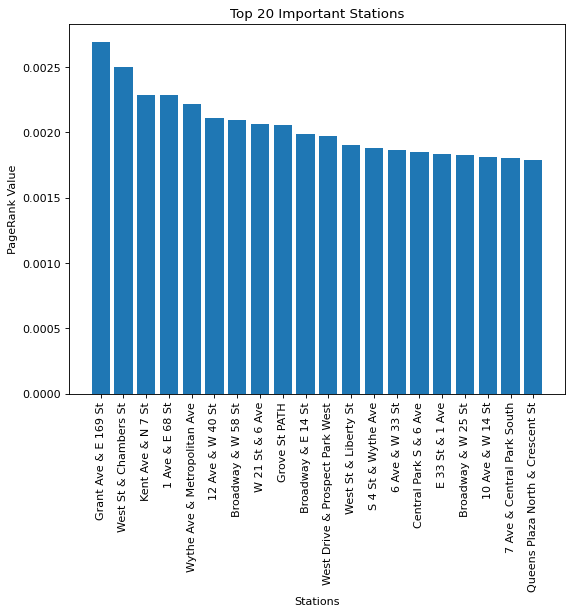

In [8]:
plt.figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=90)
plt.bar(wpr_scores_fwd.index[:20], wpr_scores_fwd.values[:20])
plt.title('Top 20 Important Stations')
plt.xlabel('Stations')
plt.ylabel('PageRank Value')

## Combining and Filtering Data

In [9]:
# Grab the top N stations according to importance in the network
n = 50  # User can define how many stations to select
top_stations = list(wpr_scores_fwd.head(n).index)
# Filter stations info for only the top N stations
top_stations_info = stations_info[stations_info.index.isin(top_stations)]
top_stations_info.shape  # Some stations are not in stations_info

(45, 4)

In [10]:
# There is discrepancy between stations that are retrived from the live station data and 
# those in citi_jul_network.
# So, the station values in `top_station_info` is used as the base
top_stations = top_stations_info.index

In [11]:
# Start
citi_jul_network_top = citi_jul_network[citi_jul_network['start_station_name'].isin(top_stations)]
citi_jul_network_top['started_at'] = pd.to_datetime(citi_jul_network_top['started_at']).dt.round('h')
citi_jul_2022_start = citi_jul_network_top.groupby(['start_station_name', 'started_at']).size().rename('start')
citi_jul_2022_start.head()

C:\Users\Ehsan\AppData\Local\Temp\ipykernel_7012\2574193657.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citi_jul_network_top['started_at'] = pd.to_datetime(citi_jul_network_top['started_at']).dt.round('h')


start_station_name  started_at         
1 Ave & E 62 St     2022-07-01 00:00:00    1
                    2022-07-01 01:00:00    4
                    2022-07-01 02:00:00    2
                    2022-07-01 04:00:00    2
                    2022-07-01 06:00:00    5
Name: start, dtype: int64

In [12]:
# End
citi_jul_network_top = citi_jul_network[citi_jul_network['end_station_name'].isin(top_stations)]
citi_jul_network_top['ended_at'] = pd.to_datetime(citi_jul_network_top['ended_at']).dt.round('h')
citi_jul_2022_end = citi_jul_network_top.groupby(['end_station_name', 'ended_at']).size().rename('end')
citi_jul_2022_end.head()

C:\Users\Ehsan\AppData\Local\Temp\ipykernel_7012\420661752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  citi_jul_network_top['ended_at'] = pd.to_datetime(citi_jul_network_top['ended_at']).dt.round('h')


end_station_name  ended_at           
1 Ave & E 62 St   2022-07-01 01:00:00    4
                  2022-07-01 02:00:00    1
                  2022-07-01 03:00:00    1
                  2022-07-01 04:00:00    1
                  2022-07-01 05:00:00    1
Name: end, dtype: int64

In [13]:
# Combining the hourly ride starts and end for each station
citi_jul_2022_hourly_combined = pd.concat(
    [citi_jul_2022_start, citi_jul_2022_end], axis=1).fillna(0).reset_index().rename(
    columns={'level_0': 'station', 'level_1': 'datetime'})
citi_jul_2022_hourly_combined.head()

,station,datetime,start,end
0,1 Ave & E 62 St,2022-07-01 00:00:00,1.0,0.0
1,1 Ave & E 62 St,2022-07-01 01:00:00,4.0,4.0
2,1 Ave & E 62 St,2022-07-01 02:00:00,2.0,1.0
3,1 Ave & E 62 St,2022-07-01 04:00:00,2.0,1.0
4,1 Ave & E 62 St,2022-07-01 06:00:00,5.0,2.0


In [14]:
# Cleaning and saving data as full time series
data = citi_jul_2022_hourly_combined
data = data[data['datetime'].isin(pd.date_range(start='7/1/2022', end='7/31/2022 23:00:00', freq='H'))]
new_index = pd.MultiIndex.from_product([data.station.unique(), data.datetime.unique()])
clean_full_time_series = data.set_index(
    ['station', 'datetime']).reindex(new_index).fillna(0).reset_index().rename(
    columns={'level_0': 'station', 'level_1': 'datetime'})
clean_full_time_series.head()

,station,datetime,start,end
0,1 Ave & E 62 St,2022-07-01 00:00:00,1.0,0.0
1,1 Ave & E 62 St,2022-07-01 01:00:00,4.0,4.0
2,1 Ave & E 62 St,2022-07-01 02:00:00,2.0,1.0
3,1 Ave & E 62 St,2022-07-01 04:00:00,2.0,1.0
4,1 Ave & E 62 St,2022-07-01 06:00:00,5.0,2.0


# Citi-Bike July 2022 ML Modeling

## Create Master ML Dataframe
This needs to be done for both trips' start and end 

In [15]:
def prep_ml_df(col):
    """
    Flattens out data. Instead of timeseries running down the rows, it runs across the columns.
    Grabbing preceding 12 hours for last week, 2 week ago.

    Forecasting one week into the future. Hourly -> 168 hours
    """
    mdf = clean_full_time_series[['station', 'datetime', col]].sort_values('datetime')
    ml_master_ls = []
    hours_prediction_horizon = 168  # hours in a week
    num_lagging_windows = hours_prediction_horizon + 12  # 12 hours leading up to time x
    # go through each chunk of data by ts_id
    for grp, df in mdf.groupby('station'):
        # add lagging demand data
        for n in range(hours_prediction_horizon, num_lagging_windows + 1):
            df[f'{col}_lag_{n}'] = df[col].shift(n)  # one week past
            df[f'{col}_lag_{n + 168}'] = df[col].shift(n + 168)  # two
        ml_master_ls.append(df)
    # bring it all back together
    ml_master_df = pd.concat(ml_master_ls, axis=0, ignore_index=True).dropna(axis=0)
    return ml_master_df, mdf

In [16]:
# Creating ML dataframe for 'start'
ml_master_df_start, master_df_start = prep_ml_df('start')
# Creating ML dataframe for 'end'
ml_master_df_end, master_df_end = prep_ml_df('end')

## Split Training and Test

### Define train-test split

In [17]:
def train_test_data(ml_df, start_end, train_test_cutoff):
    """Separate the ml_df into training and test sets
    
    we preserve the training and testing data keys to keep track of our predictions later    
    we create the data after the clustering code below    
    Note: we should add logic to make sure we dropped start from X_... datasets
    """
    # get model feature data
    train_mask = ml_df.datetime < train_test_cutoff
    X_train = ml_df[train_mask].copy()
    X_test = ml_df[~train_mask].copy()

    # get the model targets
    y_train = X_train[start_end]
    y_test = X_test[start_end]

    # drop the unused columns
    extra_cols = ['station', 'datetime', start_end]
    X_train.drop(extra_cols, axis=1, inplace=True)
    X_test.drop(extra_cols, axis=1, inplace=True)
    return X_train, y_train, X_test, y_test

In [18]:
cutoff_time = datetime.datetime(year=2022, month=7, day=27)
# Start
X_train_start, y_train_start, X_test_start, y_test_start = train_test_data(ml_master_df_start, 'start', cutoff_time)
# End
X_train_end, y_train_end, X_test_end, y_test_end = train_test_data(ml_master_df_end, 'end', cutoff_time)

## Running ML models and Testing

In [19]:
def create_ml_models(x_train, y_train, x_test, y_test):
    best_model = None
    best_model_name = None
    best_score = 0
    for name, regression in zip(['xgb', 'svm', 'linear regression'],
                                [XGBRegressor, LinearSVR, LinearRegression]):
        ml_model = regression()
        ml_model.fit(x_train, y_train)
        print(f'{name} results\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        score = r2_score(y_test, ml_model.predict(x_test))
        print(score)
        if score > best_score:
            best_score = score
            best_model = ml_model
            best_model_name = name
    print(f'\nBest model: {best_model_name}\n')
    return best_model

In [20]:
# Start
ml_model_start = create_ml_models(X_train_start, y_train_start, X_test_start, y_test_start)
# End
ml_model_end = create_ml_models(X_train_end, y_train_end, X_test_end, y_test_end)

xgb results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.6930093092386995


C:\Users\Ehsan\miniconda3\envs\bike\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


svm results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.5952978230973742
linear regression results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.7352258784069108

Best model: linear regression

xgb results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.7006771976227817
svm results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.7042649152534888
linear regression results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.7278775214037927

Best model: linear regression



C:\Users\Ehsan\miniconda3\envs\bike\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Making Predictions

In [21]:
def create_prediction_df(master_df, ml_model, col):
    ml_master_ls = []
    hours_prediction_horizon = 168  # hours in a week
    num_lagging_windows = hours_prediction_horizon + 12  # 12 hours leading up to time x
    # go through each chunk of data by ts_id
    date_range = pd.date_range(start='8/1/2022', end='8/5/2022 23:00:00', freq='H')
    for grp, df in master_df.groupby('station'):
        prediction_df = pd.DataFrame({'station': grp, col: 0, 'datetime': date_range})
        df = pd.concat([df, prediction_df], axis=0, ignore_index=True)
        # assure sorted
        df.sort_values('datetime', inplace=True)
        # add lagging demand data
        for n in range(hours_prediction_horizon, num_lagging_windows + 1):
            df[f'{col}_lag_{n}'] = df[col].shift(n)  # one week past
            df[f'{col}_lag_{n + 168}'] = df[col].shift(n + 168)  # two
        ml_master_ls.append(df)
    # bring it all back together
    ml_master_df = pd.concat(ml_master_ls, axis=0, ignore_index=True)
    prediction_master = ml_master_df[ml_master_df['datetime'].isin(date_range)]
    prediction_ml = prediction_master.drop(['station', 'datetime', col], axis=1)  # dataframe for model
    # dataframe prediction key as placeholder for forecasts
    prediction_key = prediction_master[['station', 'datetime']].copy()
    prediction_key[f'{col}_forecast'] = ml_model.predict(prediction_ml)
    return prediction_key

In [22]:
# First week of August, MON-FRI predictions
# Creating Prediction dataframe for 'start'
start_prediction_key = create_prediction_df(master_df_start, ml_model_start, 'start')
# Creating Prediction dataframe for 'end'
end_prediction_key = create_prediction_df(master_df_end, ml_model_end, 'end')
predictions_final = pd.merge(start_prediction_key, end_prediction_key, on=['station', 'datetime'])
top_stations_info.to_csv('top_stations.csv', index_label='station')
predictions_final.round(0).to_csv('stations_flow.csv', index=False)